In [39]:
from udma import *
import numpy as np
import matplotlib.pyplot as plt

In [228]:
cb=UDMA_CLASS("140.105.17.180", 7)
# cb=UDMA_CLASS("192.168.1.10", 7)
cb.connect()
cb.log(0)

[(5,), 0]

Comblock Registers

|Register | Connection |
| ----- | ---- |
|reg0_o | Config_Res_intan_A|
|reg1_o | Config_Res_intan_B|
|reg2_o | Config_Res_intan_C|
|reg3_o | Config_Res_intan_D|
|reg4_o | Read_intan(3:0)|
|reg5_o | Sys_reset (active low)|
|reg6_o | **Combintan_w_header**/nsamples |
|reg7_o | **Combintan_w_header**/sys_en |





In [240]:
def hicce_init(test_mode=0):
    # Select comblock
    cb.select_comblock(0)
    # Reset HiCCE
    cb.write_reg(5, 0) #RESET ON
    
    #Disable Acquisiton 
    cb.write_reg(4, 0)
    cb.write_reg(7, 0)

    # FIFO Clear
    cb.select_comblock(0)
    cb.write_reg(17, 1)
    cb.write_reg(17, 0)
    cb.select_comblock(1)
    cb.write_reg(17, 1)
    cb.write_reg(17, 0)
    cb.select_comblock(0)

    # Configure INTANT in Sequential mode (Reset Counter)
    cb.write_reg(0, 0x1c02+test_mode)
    cb.write_reg(1, 0x1c02+test_mode)
    cb.write_reg(2, 0x1c02+test_mode)
    cb.write_reg(3, 0x1c02+test_mode)
    # Configure INTANT (Cyclic Read)
    cb.write_reg(0, 0x26+test_mode)
    cb.write_reg(1, 0x26+test_mode)
    cb.write_reg(2, 0x26+test_mode)
    cb.write_reg(3, 0x26+test_mode)

def enable_acquisition(NSamples=100):
    cb.select_comblock(0)
    #Set number of samples per package
    cb.write_reg(6, 32*NSamples)

    #Enable acquisition
    cb.write_reg(4, 15) ##Enabling INTAN readout (legacy)
    cb.write_reg(5, 1) ##Enabling HICCE Driver
    cb.write_reg(7, 1) #Enable FIFOs
    
    

def read_channels(Ncomblock=0, NSamp=100, TO=1000):
    cb.select_comblock(Ncomblock)
    wordsInFifo=cb.read_reg(34)[1][0]>>16
    #Wait until FIFO have enough samples to read.
    wd=0
    while wordsInFifo<(32*NSamp+4):
        wordsInFifo_new=cb.read_reg(34)[1][0]>>16
        if wordsInFifo_new == wordsInFifo:
            wd+=1
            if wd==TO: #if the value doesn't change after TO iterations return error
                return -1
        else:
            wordsInFifo=wordsInFifo_new
            wd=0
    if NSamp==1:
        samples_to_read=(32*NSamp)+5
    else:
        samples_to_read=(32*NSamp)+4

    dpack=cb.read_hicce(samples_to_read)
    if dpack[0][0] == -1:
        return -1
    elif dpack[0][1] < samples_to_read:
        return -1
    else:
        return dpack[1]

def decode(dpack):
    head=dpack[0]
    CEN=(head>>16) & 0xff
    SBT=(head>>8) & 0xff
    SAT=head & 0xff
    TS=dpack[1]<<32 | dpack[2]
    TAIL=dpack[-1]
    CENT=(TAIL>>16) & 0xff
    FLAGS=TAIL & 0xffff
    
    CH=[]
    for i in range(64):
        CH.append([])
    
    for i in range(len(dpack[3:-1])):
        d=dpack[i]
        #Splitting into Most significant channel and less significant channel
        MSCH=d>>16
        LSCH=d&0xffff

        if MSCH >= 0x8000:  # Check if number is negative
            MSCH = -((MSCH ^ 0xffff) + 1) # Convert two's complement to negative number
        if LSCH >= 0x8000:  # Check if number is negative
            LSCH = -((LSCH ^ 0xffff) + 1) # Convert two's complement to negative number
        
        CH[(i%32)].append(MSCH)
        CH[(i%32)+32].append(LSCH)
         
    return CH, TS, (SBT==SAT, FLAGS==0)

In [71]:
cfg=0x26
cb.write_reg(4, 0)
cb.write_reg(5, 0)
cb.write_reg(7, 0)
cb.write_reg(0, cfg)
cb.write_reg(1, cfg)
cb.write_reg(2, cfg)
cb.write_reg(3, cfg)
cb.write_reg(4, 15)
cb.write_reg(5, 1)
cb.write_reg(7, 1)

[(1, 0), 0]

In [203]:
hicce_init(test_mode=0)
enable_acquisition(20)
ab_raw=read_channels(0,20)
CHAB, TSAB, FLAGS=decode(ab_raw)
FLAGS

[(1, 644), (16908802, 0, 1304436783, 4157409155, 102496205, 126875583, 77924281, 4143515591, 4070639470, 127207339, 4145285032, 4142200745, 129169303, 129763242, 101775261, 129169310, 127596430, 127535007, 4147578765, 4154591124, 99223434, 95684480, 4151183239, 96798072, 127076216, 126809971, 4110550890, 91424622, 91293551, 84211562, 103221081, 126814041, 125962083, 4124964704, 124913484, 4151117699, 79296331, 124979018, 94504756, 4127197013, 47515490, 4151117642, 4149610296, 4147185447, 122226510, 122484528, 62129994, 4149151545, 121309003, 4146857805, 4143056719, 122816331, 79038261, 107022146, 113575767, 94634623, 120584037, 123799385, 55904102, 92669779, 94308206, 4104062554, 104269654, 4134471562, 124651349, 103352210, 4152625049, 124057102, 83101592, 4124510071, 4119070607, 4123330445, 4045407772, 114034543, 108197757, 4133226360, 124127083, 125699959, 17041269, 125175665, 122484585, 4148758386, 113182572, 4151117669, 78051175, 64751458, 4140631899, 97648804, 124389188, 415098657

(2, 1, 2, 2, 0)

In [158]:
FLAGS

(2, 1, 2, 2, 0)

In [ ]:
cb.select_comblock(0)
print("CB FIFO Size",cb.read_reg(34)[1][0]>>16)

cb.select_comblock(1)
print("CB FIFO Size", cb.read_reg(34)[1][0]>>16)


In [155]:
cb.s.recv(1000)

KeyboardInterrupt: 

In [241]:
sampling_time=4e-9
NofIterations=50
chunksize=20

hicce_init(test_mode=0)
enable_acquisition(chunksize)
ch=[]
t=[]
for i in range(128):
    ch.append([])
for i in range(NofIterations):
    ab_raw=read_channels(0,chunksize)
    cd_raw=read_channels(1,chunksize)
    if ab_raw == -1:
        print('Error', i)
        pass
    else:
        ab_decode=decode(ab_raw)
        CHAB, TSAB, FLAGSAB=ab_decode
    if cd_raw == -1:
        pass
    else:
        CHCD, TSCD, FLAGSCD=decode(cd_raw)
    ttemp=[TSAB*sampling_time + i * sampling_time for i in range(chunksize)]
    for i in range(64):
        if FLAGSAB[0] or FLAGSAB[1] or FLAGSCD[0] or FLAGSCD[1]:
            ch[i]=ch[i]+CHAB[i]
            ch[i%64+64]=ch[i%64+64]+CHCD[i]
    t=ttemp+t

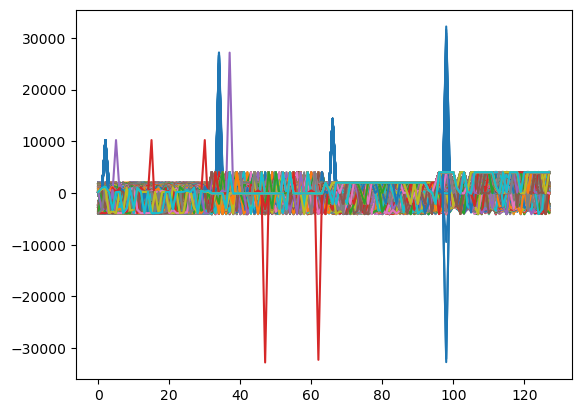

In [243]:
plt.plot(ch)

In [122]:
cb.select_comblock(1)
cb.read_reg(34)

[(4088464426, 71566241), 0]

In [124]:
cb.s.recv(1000)

KeyboardInterrupt: 

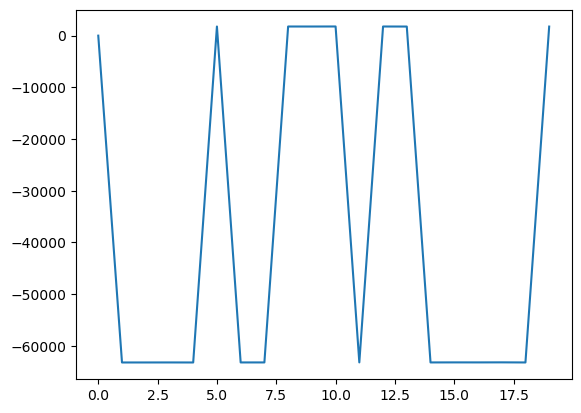

In [148]:
plt.plot(CHAB[1])

In [ ]:
for i in range(len(ch)):
    print(len(ch[1]))

In [ ]:
# hicce_init()
# enable_acquisition(20)
# ch0=[]
# for i in range(50):
#     ab_raw=read_channels(0,20)
#     CHAB, TSAB, FLAGS=decode(ab_raw)
#     ch0=ch0+CHAB[30]


In [ ]:
cb.write_reg(5,0)

In [ ]:
hicce_init()

In [22]:
hicce_init(test_mode=1)
enable_acquisition(20)
ch=[]
for i in range(64):
    ch.append([])
for i in range(1):
    ab_raw=read_channels(0,20)
    cd_raw=read_channels(1,20)
    CHAB, TSAB, FLAGS=decode(ab_raw)
    for i in range(64):
        ch[i]=ch[i]+CHAB[i]

In [35]:
%matplotlib widget
plt.plot(ch[2])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
ab_raw=read_channels(0,20)
ab=decode(ab_raw)
cd=decode(read_channels(1, 20))

In [ ]:
np.int16(ab[0][2][2])

In [ ]:
ab=decode(read_channels(0, 20))
cd=decode(read_channels(1, 20))

In [ ]:
for i in range(len(ab[0])):    
    print(len(ab[0][i]))
    # print(len(cd[0][i]))

In [ ]:
for i in range(len(ab)):
    if ab[i]>>24==0x04:
        print(i)
print(len(ab))

In [ ]:
hicce_init()
enable_acquisition(3200)

In [ ]:
ab,cd=read_channels(1, 3200)
DAB=decode(ab)
DCD=decode(cd)
#Timestamp and Channels 0-64 from AB
TSAB=DAB[3]
CHAB=DAB[4]
#Timestamp and Channels 0-64 from CD
TSCD=DCD[3]
CHCD=DCD[4]

plt.plot(CHAB[0])

In [ ]:
print(CHAB[0])

In [ ]:
plt.plot(CHAB)
plt.plot(CHCD)

In [ ]:
import pylsl
pylsl.local_clock()